In [6]:
%reset
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm
import matplotlib.gridspec as gridspec

from info import info
from pdf_computer import pdfComputer
from sst import conductSST

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Settings for plot
plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20

# Function for external forcing of non-coupled variables
def non_coupled(N):
    rxf = lambda x, t: x*(3.1*(1-x))*np.exp(-.3*t)
    ryf = lambda y, t: y*(2.9*(1-y))*np.exp(-.36*t)
    xf = lambda x, rx: 0.4*x+max(rx, 0)
    yf = lambda y, ry: 0.35*y+max(ry, 0)

    trash = 100
    x_set = np.zeros(N+trash)
    y_set = np.zeros(N+trash)
    rx_set = np.zeros(N+trash)
    ry_set = np.zeros(N+trash)
    
    rx_set[0] = np.random.rand()
    ry_set[0] = np.random.rand()
    x_set[:4] = np.random.rand(4)
    y_set[:4] = np.random.rand(4)
    
    for i in range(3):
        t = np.random.normal()
        xnow, ynow = x_set[i], y_set[i]
        rx_set[i+1] = rxf(xnow, t)
        ry_set[i+1] = ryf(ynow, t)
#     print x_set[:4], y_set[:4], rx_set[:4], ry_set[:4]
    
    for i in range(4, N+trash-1):
        xnow, ynow = x_set[i-1], y_set[i-1]
        rxnow, rynow = rx_set[i-4], ry_set[i-4]
#         print xnow, ynow, rxnow, rynow
        t = np.random.normal()
        x_set[i] = xf(xnow, rxnow)
        y_set[i] = yf(xnow, rynow)
        rx_set[i] = rxf(xnow, t)
        ry_set[i] = ryf(ynow, t)

    return x_set[trash:], y_set[trash:]

# Parameter settings
N = 1000

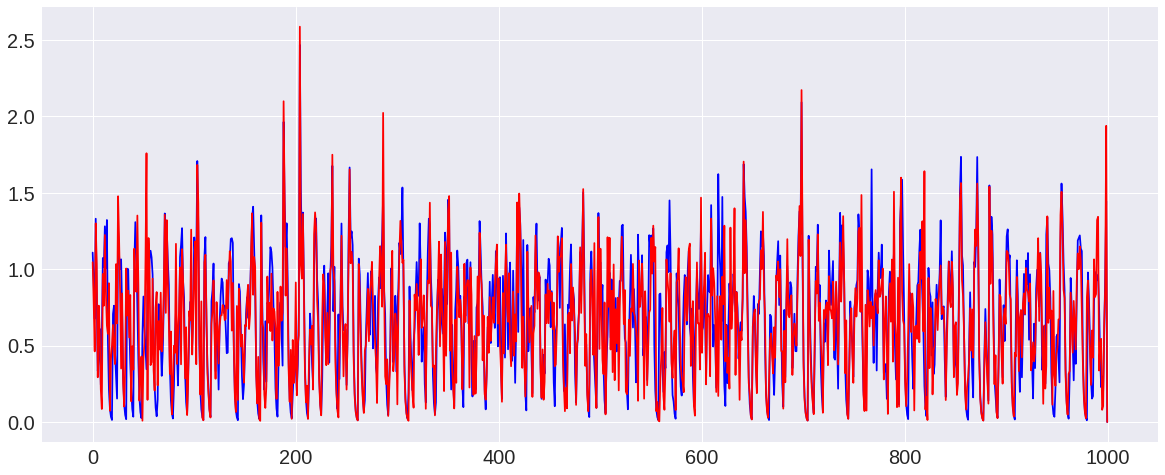

In [8]:
# Simulate
x_set, y_set = non_coupled(N)

plt.plot(range(N), x_set, 'b')
plt.plot(range(N), y_set, 'r')
plt.show()

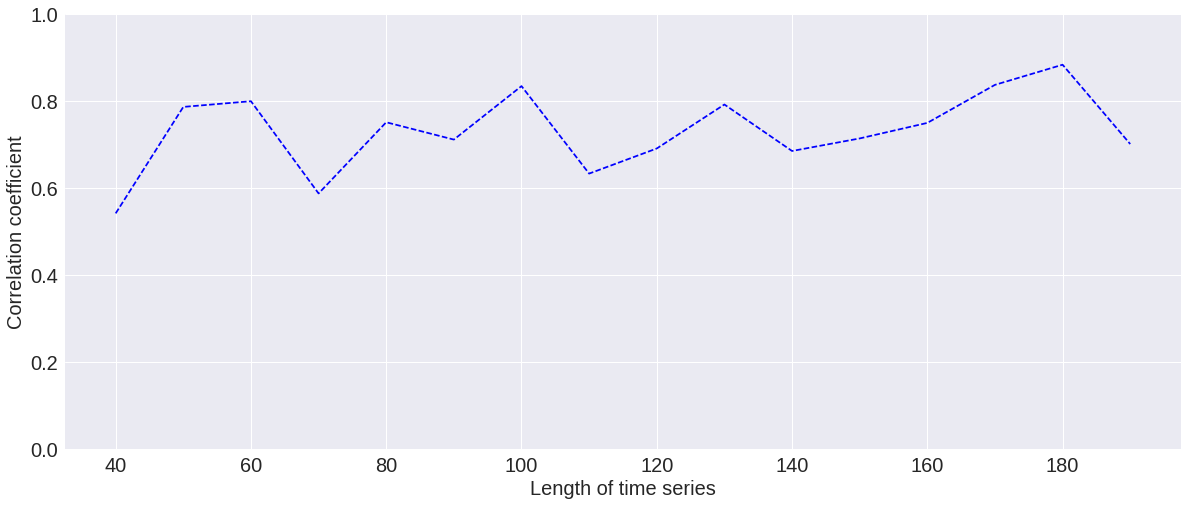

In [9]:
# Calculate the correlation coefficient given different length N
n = 10
N_set    = np.arange(40, 200, n)
corr_set = np.zeros(N_set.size)
for i in range(N_set.size):
    N = N_set[i]
    x_set, y_set = non_coupled(N)
    corr_set[i]  = np.corrcoef(x_set, y_set)[0,1]

plt.plot(N_set, corr_set, '--b')
plt.ylim([0,1])
plt.xlabel('Length of time series')
plt.ylabel('Correlation coefficient')
plt.show()

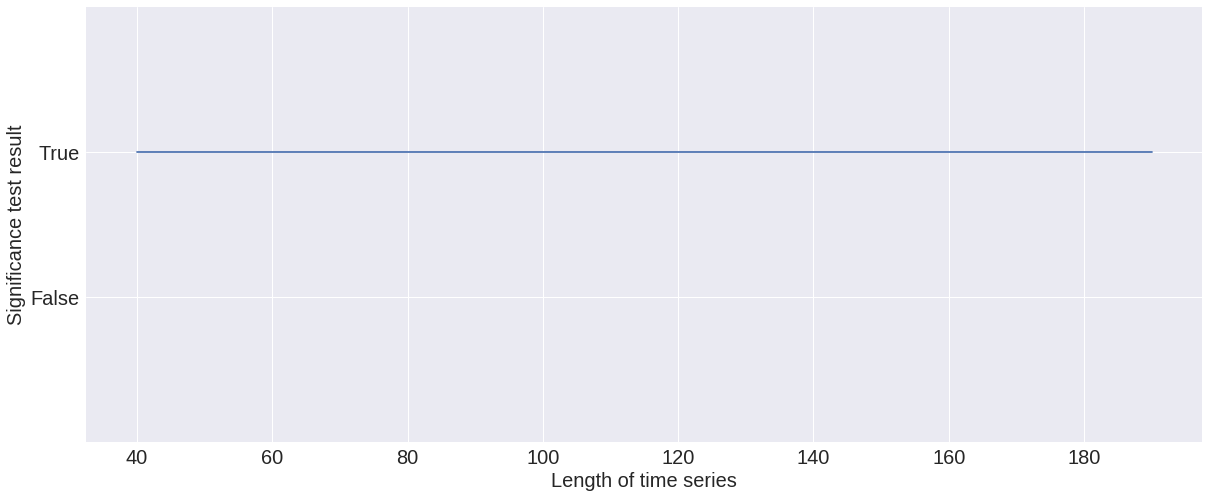

In [10]:
# Conduct the significance test of mutual information between X(t) and Y(t) given different length N
n = 10
nx,  ny  = 30, 30
N_set    = np.arange(40, 200, n)
mip_set  = np.zeros(N_set.size)
for i in range(N_set.size):
    N = N_set[i]
    x_set, y_set = non_coupled(N)
    mip_set[i]   = conductSST(x_set, y_set, nx, ny, 
                              approach='kde_cuda', atomCheck=True, returnTrue=True)[0]

plt.step(N_set, mip_set)
plt.ylim([-1,2])
plt.yticks([0, 1], ['False', 'True'])
plt.xlabel('Length of time series')
plt.ylabel('Significance test result')
plt.show()